In [73]:
from dsgd import DSClassifierMultiQ
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn.datasets import load_iris,load_wine
from sklearn.preprocessing import StandardScaler

In [74]:
iris = pd.read_csv("../clustering/data/gaussian_df.csv")
X = iris.drop(columns=['labels'])
y = iris['labels']
#aplicamos kmeans a los datos
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
#calculamos el silhouette score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")
#calculamos el adjusted rand index
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari}")
#aplicamos DBSCAN a los datos
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
dbscan_labels = dbscan.labels_
#calculamos el silhouette score
if len(set(dbscan_labels)) > 1:  # Check if there are at least two clusters
    dbscan_silhouette_avg = silhouette_score(X, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette_avg}")
    #calculamos el adjusted rand index
    dbscan_ari = adjusted_rand_score(y, dbscan_labels)
    print(f"DBSCAN Adjusted Rand Index: {dbscan_ari}")
#aplicamos Agglomerative Clustering a los datos
agglo = AgglomerativeClustering(n_clusters=2)
agglo.fit(X)
agglo_labels = agglo.labels_
#calculamos el silhouette score
agglo_silhouette_avg = silhouette_score(X, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette_avg}")
#calculamos el adjusted rand index
agglo_ari = adjusted_rand_score(y, agglo_labels)
print(f"Agglomerative Clustering Adjusted Rand Index: {agglo_ari}")

Silhouette Score: 0.6435277436707083
Adjusted Rand Index: 0.984032
Agglomerative Clustering Silhouette Score: 0.6435277436707083
Agglomerative Clustering Adjusted Rand Index: 0.984032


In [75]:
print("Clustering results:")
#printeamos candidad de clusters
print(f"KMeans clusters: {len(set(labels))}")
print(f"DBSCAN clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Agglomerative Clustering clusters: {len(set(agglo_labels))}")

Clustering results:
KMeans clusters: 2
DBSCAN clusters: 1
Agglomerative Clustering clusters: 2


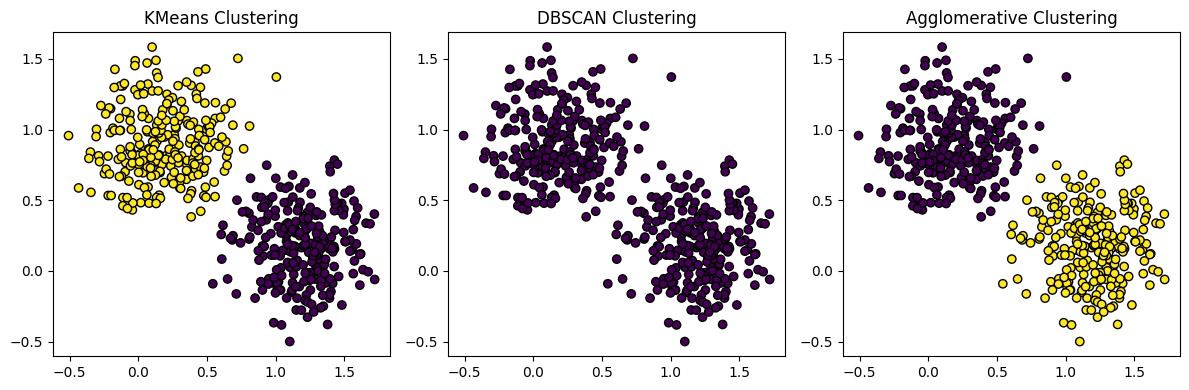

In [76]:
#visualizamos los resultados con pca
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('KMeans Clustering')
plt.subplot(1, 3, 2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering')
plt.subplot(1, 3, 3)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=agglo_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('Agglomerative Clustering')
plt.tight_layout()
plt.show()

In [77]:
DSC = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7, precompute_rules=True)
X_values = X.values
losses, epoch, dt = DSC.fit(X_values, labels, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X.columns)
#calculamos el silhouette score ccon las predicciones de DSC
predictions = DSC.predict(X_values)
silhouette_avg_dsc = silhouette_score(X_values, predictions)
print(f"DSC Silhouette Score: {silhouette_avg_dsc}")
#calculamos el adjusted rand index
dsc_ari = adjusted_rand_score(y, predictions)
print(f"DSC Adjusted Rand Index: {dsc_ari}")

Optimization started

Training time: 16.12s, epochs: 200

Least training loss reached: 0.027
DSC Silhouette Score: 0.6228243739102449
DSC Adjusted Rand Index: 0.8909174116090074


In [78]:
#printea los medoids de kmeans
print("KMeans Medoids:")
medoids = kmeans.cluster_centers_
for i, medoid in enumerate(medoids):
    print(f"Medoid {i}: ", end="")
    print(", ".join([f"{feature_name}: {value}" for feature_name, value in zip(X.columns, medoid)]))
DSC.print_most_important_rules(threshold=0.32)

KMeans Medoids:
Medoid 0: x: 1.1928591125867567, y: 0.18145611956065327
Medoid 1: x: 0.17778860369263239, y: 0.9035088808842218


Most important rules for class 0

	[0.758] R3: x > 1.067
			0: 0.758	1: 0.000	Unc: 0.242

	[0.636] R2: 0.685 < x < 1.067
			0: 0.636	1: 0.000	Unc: 0.364

	[0.565] R4: y < 0.247
			0: 0.565	1: 0.000	Unc: 0.435

	[0.484] R5: 0.247 < y < 0.542
			0: 0.478	1: 0.012	Unc: 0.510

Most important rules for class 1

	[0.789] R0: x < 0.304
			0: 0.000	1: 0.789	Unc: 0.211

	[0.632] R1: 0.304 < x < 0.685
			0: 0.000	1: 0.632	Unc: 0.368

	[0.581] R7: y > 0.838
			0: 0.000	1: 0.581	Unc: 0.419

	[0.463] R6: 0.542 < y < 0.838
			0: 0.000	1: 0.463	Unc: 0.536


In [79]:
import pandas as pd
rules = DSC.find_most_important_rules(threshold=0.32)
rows = []
for cls, found in rules.items():
    for score, i, ps, sqrt_score, ms in found:
        row = {
            'class': cls,
            'rule_index': i,
            'rule': ps,
            'score': float(score),
            'sqrt_score': float(sqrt_score)
        }
        # separa las masas en columnas individuales
        if hasattr(ms, 'tolist'):
            masses_list = ms.tolist()
        else:
            masses_list = list(ms)
        for idx, mass in enumerate(masses_list):
            row[f'mass_{idx+1}'] = mass
        rows.append(row)
rules_df = pd.DataFrame(rows)
rules_df

,class,rule_index,rule,score,sqrt_score,mass_1,mass_2,mass_3
0,0,3,x > 1.067,0.574603,0.758026,0.758026,0.000000,0.241974
1,0,2,0.685 < x < 1.067,0.404542,0.636036,0.636036,0.000000,0.363964
2,0,4,y < 0.247,0.319178,0.564958,0.564958,0.000000,0.435042
3,0,5,0.247 < y < 0.542,0.234239,0.483982,0.478260,0.011513,0.510227
4,1,0,x < 0.304,0.622036,0.788692,0.000000,0.788692,0.211308
5,1,1,0.304 < x < 0.685,0.399282,0.631888,0.000000,0.631888,0.368112
6,1,7,y > 0.838,0.337602,0.581035,0.000000,0.581035,0.418965
7,1,6,0.542 < y < 0.838,0.214795,0.463460,0.000202,0.463359,0.536439


In [80]:
#analizamos un dato random por clase en kmeans para ver que tan bien se agrupan
print(iris.columns)
for i in range(2):
    print(f"Cluster {i}:")
    cluster_data = X[labels == i]
    if len(cluster_data) > 0:
        random_idx = np.random.choice(cluster_data.shape[0], 1, replace=False)[0]
        random_data = cluster_data.iloc[random_idx].values
        print(f"Random data from cluster {i}: ", end="")
        print(", ".join([f"{feature_name}: {value}" for feature_name, value in zip(X.columns, random_data)]))
        pred, cls, df_rls, builder = DSC.predict_explain(random_data)
        print(pred, cls)
        print(df_rls)
    else:
        print(f"No data in cluster {i}")

Index(['x', 'y', 'labels'], dtype='object')
Cluster 0:
Random data from cluster 0: x: 1.1586505889084024, y: 0.0738242875029979
[0.90475714 0.09524282] 0
        rule  mass_class_1  mass_class_2  uncertainty
0  x > 1.067      0.758026           0.0     0.241974
1  y < 0.247      0.564958           0.0     0.435042
Cluster 1:
Random data from cluster 1: x: 0.5603358585888762, y: 1.0792330036305666
[0.13361852 0.86638147] 1
                rule  mass_class_1  mass_class_2  uncertainty
0  0.304 < x < 0.685           0.0      0.631888     0.368112
1          y > 0.838           0.0      0.581035     0.418965


In [81]:
#como puedo ver si los clusters repreentan el mismo grupo entre kmeans y agglomerative clustering?
def compare_clusters(labels1, labels2):
    # Create a contingency table
    contingency_table = pd.crosstab(labels1, labels2)
    print("Contingency Table:")
    print(contingency_table)

    # Calculate the Pearson correlation coefficient
    corr, _ = pearsonr(labels1, labels2)
    print(f"Pearson correlation coefficient: {corr}")
    
compare_clusters(labels, agglo_labels)

#como podria usar eso para normalizar los clusters, es decir que los clusters de kmeans y agglomerative clustering representen el mismo grupo?def normalize_clusters(labels1, labels2):
    # Create a mapping from labels1 to labels2
def normalize_clusters(labels1, labels2):
    # Create a mapping from labels1 to labels2
    unique_labels1 = np.unique(labels1)
    unique_labels2 = np.unique(labels2)
    
    mapping = {}
    for label1 in unique_labels1:
        # Find the most common label2 for each label1
        mask = (labels1 == label1)
        most_common_label2 = pd.Series(labels2[mask]).mode()[0]
        mapping[label1] = most_common_label2
    
    # Apply the mapping to labels1
    normalized_labels1 = np.array([mapping[label] for label in labels1])
    
    return normalized_labels1   
normalized_labels = normalize_clusters(labels, agglo_labels)
compare_clusters(normalized_labels, agglo_labels)

Contingency Table:
col_0    0    1
row_0          
0        0  250
1      250    0
Pearson correlation coefficient: -1.0
Contingency Table:
col_0    0    1
row_0          
0      250    0
1        0  250
Pearson correlation coefficient: 1.0


In [82]:
#quiero usar normalized_labels + anglolabels para predecir, duplicamos X
X_combined = np.concatenate((X, X), axis=0)
normalized_labels_combined = np.concatenate((normalized_labels, agglo_labels), axis=0)
DSC = DSClassifierMultiQ(3, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
losses, epoch, dt = DSC.fit(X_combined, normalized_labels_combined, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X.columns)
DSC.print_most_important_rules(threshold=0.32)
#calculamos el silhouette score ccon las predicciones de DSC
predictions = DSC.predict(X)
silhouette_avg_dsc = silhouette_score(X, predictions)
print(f"DSC Silhouette Score: {silhouette_avg_dsc}")
#calculamos el adjusted rand index con las predicciones de DSC
dsc_ari = adjusted_rand_score(y, predictions)
print(f"DSC Adjusted Rand Index: {dsc_ari}")

Optimization started

Training time: 36.77s, epochs: 200

Least training loss reached: 0.021


Most important rules for class 0

	[0.746] R0: x < 0.304
			0: 0.746	1: 0.000	2: 0.000	Unc: 0.254

	[0.734] R7: y > 0.838
			0: 0.734	1: 0.000	2: 0.000	Unc: 0.266

	[0.700] R1: 0.304 < x < 0.685
			0: 0.700	1: 0.000	2: 0.000	Unc: 0.300

	[0.654] R6: 0.542 < y < 0.838
			0: 0.605	1: 0.103	2: 0.000	Unc: 0.292

	[0.474] R5: 0.247 < y < 0.542
			0: 0.263	1: 0.591	2: 0.000	Unc: 0.146

Most important rules for class 1

	[0.756] R3: x > 1.067
			0: 0.000	1: 0.756	2: 0.000	Unc: 0.244

	[0.751] R2: 0.685 < x < 1.067
			0: 0.000	1: 0.751	2: 0.000	Unc: 0.249

	[0.711] R4: y < 0.247
			0: 0.000	1: 0.711	2: 0.000	Unc: 0.289

	[0.710] R5: 0.247 < y < 0.542
			0: 0.263	1: 0.591	2: 0.000	Unc: 0.146

Most important rules for class 2
DSC Silhouette Score: 0.6322244592909906
DSC Adjusted Rand Index: 0.929154044581963


In [83]:
import pandas as pd
rules = DSC.find_most_important_rules(threshold=0.32)
rows = []
for cls, found in rules.items():
    for score, i, ps, sqrt_score, ms in found:
        row = {
            'class': cls,
            'rule_index': i,
            'rule': ps,
            'score': float(score),
            'sqrt_score': float(sqrt_score)
        }
        # separa las masas en columnas individuales
        if hasattr(ms, 'tolist'):
            masses_list = ms.tolist()
        else:
            masses_list = list(ms)
        for idx, mass in enumerate(masses_list):
            row[f'mass_{idx+1}'] = mass
        rows.append(row)
rules_df = pd.DataFrame(rows)
rules_df

,class,rule_index,rule,score,sqrt_score,mass_1,mass_2,mass_3,mass_4
0,0,0,x < 0.304,0.557189,0.746451,0.746451,0.000000,0.0,0.253549
1,0,7,y > 0.838,0.538225,0.733638,0.733638,0.000000,0.0,0.266362
2,0,1,0.304 < x < 0.685,0.489613,0.699724,0.699724,0.000000,0.0,0.300276
3,0,6,0.542 < y < 0.838,0.428334,0.654473,0.604930,0.103142,0.0,0.291928
4,0,5,0.247 < y < 0.542,0.225025,0.474369,0.263432,0.590776,0.0,0.145792
5,1,3,x > 1.067,0.571154,0.755748,0.000000,0.755748,0.0,0.244252
6,1,2,0.685 < x < 1.067,0.563563,0.750708,0.000000,0.750708,0.0,0.249292
7,1,4,y < 0.247,0.505504,0.710988,0.000000,0.710988,0.0,0.289012
8,1,5,0.247 < y < 0.542,0.504646,0.710384,0.263432,0.590776,0.0,0.145792
